 # **AI Machine Learning & Analitics Final Project**
Emiliano Martínez Kuri - Mayer Attie - Louis Petitdidier - Tomás Ward - Juan Bautista Beyhaut

**Chosen topic**
Image classification – Recognizing natural scenes

*Building a classification system that recognizes when pictures include different 
elements of a city or nature based on previously labelled images.*

AI was used occasionally to check and modify code. All code provided was well understood by the group and re-checked.

### **Background information & analisis**

For this project, we are going to develop a multiclass classification model, which implies classifying images in a series of possible categories. In multiclass classification, the objective is ot assign a unique class to every image from a predefined pool of existing classes. In this case: "buildings", "forest", "glacier", "mountain", "sea" and "street". This type of problems involving image recognition require a robust model capable of learning and differentiating between distinctive characteristics of each class.

As a first approach to developing our model, we will explore **transfer learning**. Instead of building a model from scratch, transfer learning will help us take advantage of already-existing models that werre trained on large datasets. We hope this will allow us to include complex feature extraction to our model already learnt and adapt them to our dataset through fine-tuning. 

Some of the pretrained models to consider that we could find inlcude:

1. **VGG16/VGG19**: Characterised by their relatively simple structute of 3x3 convolutional layers, efective in hierarchical feature extraction. Nonetheless, we found they can be take up a lot of memory (memory intensive) and can be prone to overfitting. **Link**: https://keras.io/api/applications/vgg/#vgg16-function

2. **ResNet (ResNet50 or ResNet101)**: Its architecture uses residual connexions allowing for a more efficient travelling of gradients in deep networks. It is ideal to capture specific details, such as textures in both nature and urban images, although it can be computational expensive. Total of 177 layers consisting of 5 stages (conv1 to conv5). Given the small size of the dataset, probably wise to freeze all layers until conv4 (included) for basic and mid-level feature extraction and let only layers in conv5 trainable (higher-level features) **Link**: https://keras.io/api/applications/resnet/#resnet50-function

3. **EfficientNet**: Consists of 237 layers including ocnvolutional, batch normalisation, activation and pooling layers. Uses a scaled compound to optimise the size and computational efficiency. Adaptable to small and deeper networks, offers a high precision without demanding a lot of resources. **Link**: https://keras.io/api/applications/efficientnet/#efficientnetb0-function


In this project, we will start by experimenting with **EfficientNetB0**, **ResNet** and **VGG16**. Warnings: ResNet can be computationallly expensive, while VGG16 and EfficientNet are simpler

### **Code**

In [112]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [113]:
# Function to load labelled data from the source folders 
def load_images(data_dir):
    labels = []
    images = []
    classes = sorted(os.listdir(data_dir))  # Get the folders/classes (labels)

    # Loop through all folders
    for idx, class_name in enumerate(classes):
        class_folder = os.path.join(data_dir, class_name)
        print('Loading class %s' %class_name)
        
        if os.path.isdir(class_folder):
            # Loop through each image file within the class folder
            for img_name in os.listdir(class_folder)[0:1000]:
                img_path = os.path.join(class_folder, img_name)

                try:
                    # Load the image, resize it, and convert to a numpy array
                    img = Image.open(img_path)
                    img = img.resize((96,96)) # Resize in case there are images of different sizes and channels
                    img_array = np.array(img)

                    # Add the image to the list and its corresponding label (class index)
                    images.append(img_array)
                    labels.append(idx)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
    
    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels, classes

In [114]:
# Actually load the data from the folders
data_dir_train = '../data/seg_train'
data_dir_test = '../data/seg_test'

x_train, y_train, train_classes = load_images(data_dir_train)
x_test, y_test, test_classes = load_images(data_dir_test)

print(f"\nLoaded trian_images: {x_train.shape}")
print(f"Loaded train_labels: {y_train.shape}")
print(f"train_Classes: {train_classes}")

print(f"\nLoaded test_images: {x_test.shape}")
print(f"Loaded test_labels: {y_test.shape}")
print(f"test_Classes: {test_classes}")

Loading class buildings
Loading class forest
Loading class glacier
Loading class mountain
Loading class sea
Loading class street
Loading class buildings
Loading class forest
Loading class glacier
Loading class mountain
Loading class sea
Loading class street

Loaded trian_images: (6000, 96, 96, 3)
Loaded train_labels: (6000,)
train_Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

Loaded test_images: (3000, 96, 96, 3)
Loaded test_labels: (3000,)
test_Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


### **Data Preprocessing**

In [115]:
# Validation split of training data:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Normalization
x_train, x_test, x_val = x_train / 255.0, x_test / 255.0, x_val / 255.0

# One hot encoding
y_train = to_categorical(y_train, 6) # Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
y_val = to_categorical(y_val, 6)
y_test = to_categorical(y_test, 6)

[0. 0. 0. 1. 0. 0.]


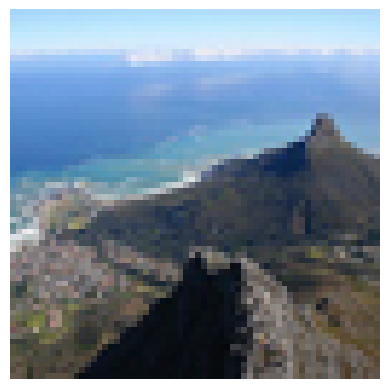

In [108]:
# Check if data is formatted correctly
print(y_train[0]) #Shows the one hot encoding and classification of the first image

plt.imshow(x_train[0])
plt.axis('off')
plt.show()

In [116]:
# Checking for class imbalances

def plot_class_distribution(y, dataset_name):
    # If one-hot encoded, convert back to class labels
    if len(y.shape) > 1 and y.shape[1] > 1:
        y = np.argmax(y, axis=1)
    
    class_counts = np.bincount(y)
    classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
    
    plt.bar(classes, class_counts, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Samples')
    plt.title(f'Class Distribution in {dataset_name} Set')
    plt.xticks(rotation=45)
    plt.show()
    
    print(f'Class counts in {dataset_name} set:', dict(zip(classes, class_counts)))

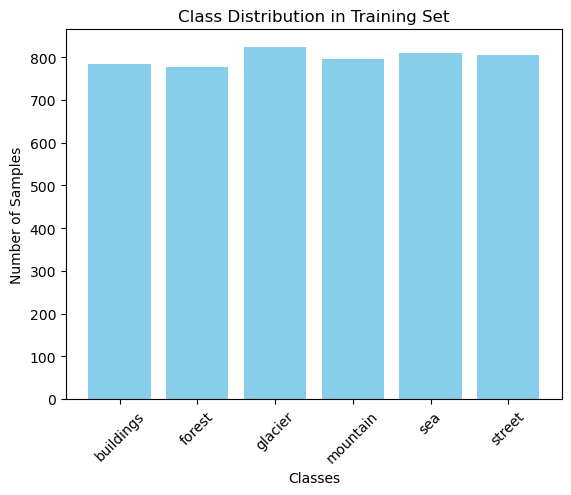

Class counts in Training set: {'buildings': 785, 'forest': 778, 'glacier': 824, 'mountain': 796, 'sea': 811, 'street': 806}


In [117]:
plot_class_distribution(np.argmax(y_train, axis=1), 'Training')

**Interpretation**: No significant class imbalances

#### **Data Augmentation**


Our dataset is limited in size containing only 6000 images in the train set and 3000 in the test set. This could represent an issue when training our models because of the lack of available data to learn complex patterns and features. A common consequence when working with small datasets is that models are prone to overfitting, where the model tends to memorize the training data and does not learn how to generalize new data effectively.

To tackle this issue, we will implement data augmentation techniques through random transformations, such as rotations, flips and zooms. This transformations will not only increase the available training data (by generating new versions of the existing pool of images), but also help preventing overfitting and improve the generalizing capacity of the models. This strategy is highly backed by previous studies that demonstrate its effectiveness (especially in small datasets). For example, a study on calssification of vehicle plates with limited amount of training data available achieved significantly better model accuracy, reaching 96% on the test set, due to the use of data augmentation techniques (Masar Abed Uthaib & Croock, 2021)

As mentioned, data augmentation is also proved to reduce overfitting and improve the model generalisation capacity in scenarios where available data is limited. I another study, the combination of transfer learning and data augmentation helped reduce overfitting of CNN models trained with small sets of images derived from the internet, demonstrating that this strategy is effective to build robust models (Han et al., 2018)

It is also important to consider any class imbalance and their potential effect on model performance. In this sense, data augmentation also offers the possibility to implement augmentation techniques to specific classes (i.e. unrepresented classes). These strategies generate specific transformations for each class, maximizing the effectiveness of data augmentation by adapting it to potential dominance of some classes over others (Yoo & kang, 2023). This is a smart point to consider.

Summarizing the previous ideas, data augmentation can be especially crucial for our context given the limited image data in our training set, allowing us approach overfitting and enhancing test accuracy more effectively. 

Links of studies:
- https://consensus.app/papers/multiclassification-license-plate-based-convolution-uthaib/44ad6d5313c750f19a1649daf1b33ed0
- https://consensus.app/papers/image-classification-method-using-transfer-learning-data-han/963bcdde94af525c8e01a98cc684fe6f
- https://consensus.app/papers/classadaptive-data-augmentation-image-classification-yoo/ed8e3540b7be5a2dbebdd100803a5389

In [ ]:
# Data augmentation transformations

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


### **Transfer Leanrning**: Implementing Pre-trained Models - **ResNet50, VGG16, EfficientNetB0**

**Note**: While we used **bayesian optimization** to search for best hyperparameters for the ResNet50 and VGG16, this proved to be extremely time consuming and very computationally expensive. For the EfficientNetB0 (the last of the three pretrained models we tried), we explored fine tuning parameters manually.

In [125]:
# Imports
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

#### **ResNet50**


In [126]:
# Defining Model-Building function for keras tuner

def build_model_ResNet50(hp):
    # Load the ResNet50 base model
    base_model_ResNet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    
  # Freeze all layers up to and including conv4 (up to layer 143)
    for layer in base_model_ResNet50.layers[:144]: # lower trainable layerss
        layer.trainable = False

    x = base_model_ResNet50.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)     # 50% dropout layer
    
    # Tune the number of units in the dense layer
    units = hp.Int('units', min_value=64, max_value=256, step=64)
    x = Dense(units, activation='relu')(x)
    
    # Output layer
    x = Dense(6, activation='softmax')(x)
    
    model = Model(inputs=base_model_ResNet50.input, outputs=x)
    
    # Tune the learning rate
    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [127]:
# Initialise Bayesian optimisation tuner

tuner = kt.BayesianOptimization(
    build_model_ResNet50,
    objective='val_accuracy',
    max_trials=10,  # Number of different hyperparameter combinations to try
    directory='my_dir',
    project_name='resnet50_tuning'
)


In [ ]:
# Run Hyperparameter search (with data augmentation on the train set)

tuner.search(datagen.flow(x_train, y_train, batch_size=32),
             epochs=5,
             validation_data=(x_val, y_val))


Trial 10 Complete [00h 03m 38s]
val_accuracy: 0.5241666436195374

Best val_accuracy So Far: 0.6191666722297668
Total elapsed time: 00h 35m 16s


In [130]:
# Get the best model from Bayesian Search

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model_ResNet50 = tuner.hypermodel.build(best_hps)

print(f"Optimal number of units: {best_hps.get('units')}")
print(f"Optimal learning rate: {best_hps.get('learning_rate')}")


Optimal number of units: 256
Optimal learning rate: 0.0001


In [ ]:
# Quick view of the resulting model architecture
#model_ResNet50.summary(); 

In [132]:
# Training the model using data augmentation (with early stopping):

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model_ResNet50.fit(datagen.flow(x_train, y_train, batch_size=32),
                    epochs=10,
                    validation_data=(x_val, y_val), 
                    callbacks=early_stopping)

Epoch 1/10


/Users/juanbabeyhaut/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 44s 249ms/step - accuracy: 0.3338 - loss: 1.6799 - val_accuracy: 0.3800 - val_loss: 1.7110
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 37s 247ms/step - accuracy: 0.4923 - loss: 1.2989 - val_accuracy: 0.4350 - val_loss: 1.4395
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 251ms/step - accuracy: 0.5006 - loss: 1.2711 - val_accuracy: 0.5258 - val_loss: 1.1623
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 37s 245ms/step - accuracy: 0.5230 - loss: 1.2096 - val_accuracy: 0.5767 - val_loss: 1.0891
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 37s 249ms/step - accuracy: 0.5299 - loss: 1.2172 - val_accuracy: 0.6167 - val_loss: 1.0282
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 277ms/step - accuracy: 0.5304 - loss: 1.1845 - val_accuracy: 0.5917 - val_loss: 1.0380
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 45s 297ms/step - accuracy: 0.5542 - loss: 1.1652 - val_accuracy: 0.6333 - val_loss: 0.9844
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 45s 300ms/step - accuracy: 0.5699 - loss: 1.1174 - val

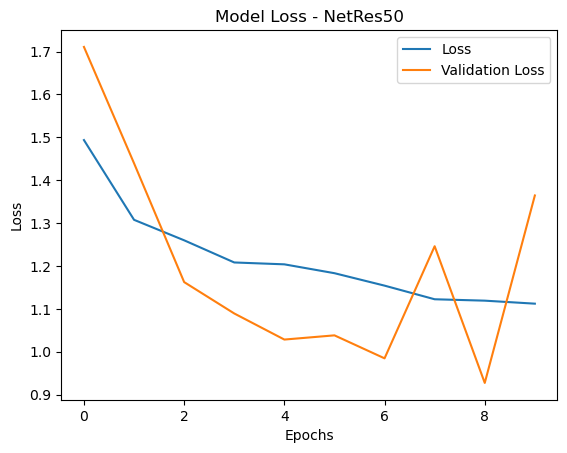

94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.7251 - loss: 0.8482
Test accuracy: 0.64


In [134]:
# Evaluate the model

plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss - NetRes50")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

test_loss, test_accuracy = model_ResNet50.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")

**Interpretation**: 

The test accuracy of 0.64 indicates that the model is not generalising very well. The training loss steadily decreases but the validation loss decreases initially and then starts to spike up and down at around epoch 5-6 and eventually increase indicating **overfitting**. We could experiment with lower learning rates (<0.0001) but the validation trends and accuracy suggest limited space for improvement using ResNet50 due to overfitting. ResNet50 appears to be too complex for out dataset. While we could continue exploring with and fine tuning ResNet, we decide to move on to simpler models VGG16 and EfficientNet-B0, at least for now.


**Next Steps**: try lighter models VGG16, EfficientNet.

#### **VGG16**

**Important Note on VGG16**: the fine tuning of VGG16 was not included in this notebook. We decided to exclude this part as we were not able to improve performance, maximum test accuracy obtained for VGG16 was 87% (below), and the best model found (as you'll see) was EfficientNetB0.

In [94]:
# Import
from tensorflow.keras.applications import VGG16

In [135]:
# Define the model-building function for Bayesian Optimization

def build_model_VGG16(hp):
    # Load the VGG16 base model without the top layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

    # Freeze a few first layers
    for layer in base_model.layers[:15]:
        layer.trainable = False

    # Add custom layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    
    # Tune the number of units in the dense layer
    units = hp.Int('units', min_value=64, max_value=256, step=64)
    x = Dense(units, activation='relu')(x)
    
    # Output layer
    x = Dense(6, activation='softmax')(x)
    
    # Define the complete model
    model = Model(inputs=base_model.input, outputs=x)
    
    # Tune the learning rate
    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [136]:
# Initialize the Bayesian optimisation tuner

tuner = kt.BayesianOptimization(
    build_model_VGG16,
    objective='val_accuracy',
    max_trials=10,  # Number of hyperparameter combinations to try
    directory='vgg16_tuner',
    project_name='vgg16_tuning'
)


In [ ]:
# Hyperparameter search (Using Data Augmentation on the train set - previously defined)

tuner.search(datagen.flow(x_train, y_train, batch_size=32),
             epochs=5,
             validation_data=(x_val, y_val))


In [ ]:
# Get the best model from bayesian optimization

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters
model_VGG16 = tuner.hypermodel.build(best_hps)


In [140]:
# Training without early stopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training with data augmentation in traininn data
history = model_VGG16.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=50, validation_data=(x_val, y_val), callbacks=early_stopping)

Epoch 1/50


/Users/juanbabeyhaut/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 61s 378ms/step - accuracy: 0.4912 - loss: 1.2966 - val_accuracy: 0.8275 - val_loss: 0.4917
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 59s 392ms/step - accuracy: 0.7351 - loss: 0.7008 - val_accuracy: 0.8333 - val_loss: 0.4605
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 60s 400ms/step - accuracy: 0.7954 - loss: 0.6031 - val_accuracy: 0.8483 - val_loss: 0.4448
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 71s 471ms/step - accuracy: 0.8156 - loss: 0.5078 - val_accuracy: 0.8242 - val_loss: 0.4616
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 88s 585ms/step - accuracy: 0.8170 - loss: 0.4909 - val_accuracy: 0.8433 - val_loss: 0.4367
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 84s 557ms/step - accuracy: 0.8324 - loss: 0.4674 - val_accuracy: 0.8700 - val_loss: 0.3741
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 86s 574ms/step - accuracy: 0.8492 - loss: 0.4224 - val_accuracy: 0.8567 - val_loss: 0.4161
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 89s 591ms/step - accuracy: 0.8584 - loss: 0.4081 - val

In [ ]:
# Quick view of the model architecture
#model_VGG16.summary()

In [ ]:
# Evaluating the model

plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss - VGG16")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

test_loss, test_accuracy = model_VGG16.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")

**Interpretation**:  

The high test accuracy of 0.87 indicates that the model generalises relatively well. The training loss steadily decreases while the validation loss decreases subtly initially but then starts to spike up and down at around epoch 5-6 (and eventually increases indicating potential **overfitting**). VGG16 appears to be a sufficiently good model to have as a base.


**Next Steps**: try EfficientNetB0, then determine which of the pretrained models to fine tune.

#### **EfficientNet** - (BEST MODEL FOUND)

**Important Note on EfficientNet**: As you'll find in this section, the fine tuning in this notebook for EfficientNet only includes lr and regularization. We still tried other approaches, namely: we trained the model with all layers frozen, all-but-last-10 layers frozen, and all-but-50 layers frozen (on a different notebook). We decided not to include their results since the test accuracies obtained from these trials were 20-30% (poor performance)

#### First Attempt **efficient0** - Baseline EfficientNetB0 architecture

In [ ]:
# Define model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

efficient0 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(6, activation='softmax')
])

# Leaving all layers trainable (as a first attempt)

# Compile 
efficient0.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


In [104]:
# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=15,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,
    patience=3,             
    min_lr=1e-6
)

# Train
history = efficient0.fit(
    datagen.flow(x_train, y_train, batch_size=32), 
    validation_data=(x_val, y_val),                
    epochs=60,                                     
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 65s 321ms/step - accuracy: 0.4248 - loss: 1.4483 - val_accuracy: 0.1858 - val_loss: 1.8016 - learning_rate: 1.0000e-04
Epoch 2/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 47s 313ms/step - accuracy: 0.7931 - loss: 0.5912 - val_accuracy: 0.1408 - val_loss: 1.8832 - learning_rate: 1.0000e-04
Epoch 3/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 46s 305ms/step - accuracy: 0.8270 - loss: 0.4839 - val_accuracy: 0.3758 - val_loss: 1.6193 - learning_rate: 1.0000e-04
Epoch 4/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 49s 327ms/step - accuracy: 0.8492 - loss: 0.4087 - val_accuracy: 0.6517 - val_loss: 1.0312 - learning_rate: 1.0000e-04
Epoch 5/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 57s 376ms/step - accuracy: 0.8735 - loss: 0.3554 - val_accuracy: 0.8442 - val_loss: 0.4337 - learning_rate: 1.0000e-04
Epoch 6/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 58s 386ms/step - accuracy: 0.8926 - loss: 0.3064 - val_accuracy: 0.8958 - val_loss: 0.2835 - learning_rate: 1.0000e-04
Epoch 7/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 56s 37

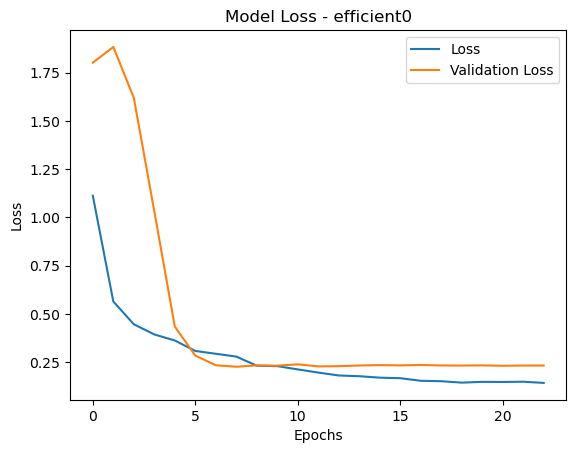

94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.9162 - loss: 0.2571
Test accuracy: 0.91
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step
Precision: 0.91
F1 Score: 0.91


In [ ]:
# Evaluation

plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss - efficient0")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

test_loss, test_accuracy = efficient0.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")

**Interpretation**: 

**Smooth Convergence**: Both losses decrease smoothly without significant divergence or instability (model is well-regularized and generalizing well).

**Validation Loss Plateau**: The validation loss plateaus around epoch 10. Suggests the lr scheduler and early stopping worked effectively.

**Minimal Overfitting**: The gap between training and validation loss is small, showing that the model is not overfitting.
This is a strong sign that the model architecture, data augmentation, and regularization techniques are well-balanced.


**Next Steps**: Fine tune the model and training process

#### **efficient1** - lowering lr and adjusting dropout (from 0.3 to 0.5) to prevent minimal overfitting

In [ ]:
# Define model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

efficient1 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),   # Increased dropout for potential overfitting
    Dense(6, activation='softmax')
])


# Compile 
optimizer = Adam(learning_rate=1e-5)    # Lowered lr
efficient1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [96]:
# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10,    # Adjusted patience to train for longer and allow learning of more features
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,
    patience=3,             
    min_lr=1e-6
)

# Train
history = efficient1.fit(
    datagen.flow(x_train, y_train, batch_size=32), 
    validation_data=(x_val, y_val),                
    epochs=60,                                     
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/60


/Users/juanbabeyhaut/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 65s 329ms/step - accuracy: 0.1726 - loss: 2.0803 - val_accuracy: 0.2075 - val_loss: 1.8075 - learning_rate: 1.0000e-05
Epoch 2/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 48s 319ms/step - accuracy: 0.2535 - loss: 1.8241 - val_accuracy: 0.1450 - val_loss: 1.9072 - learning_rate: 1.0000e-05
Epoch 3/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 47s 314ms/step - accuracy: 0.3376 - loss: 1.6245 - val_accuracy: 0.1775 - val_loss: 1.8686 - learning_rate: 1.0000e-05
Epoch 4/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 48s 316ms/step - accuracy: 0.4251 - loss: 1.4568 - val_accuracy: 0.3208 - val_loss: 1.6622 - learning_rate: 1.0000e-05
Epoch 5/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 48s 319ms/step - accuracy: 0.5148 - loss: 1.2941 - val_accuracy: 0.5458 - val_loss: 1.2738 - learning_rate: 1.0000e-05
Epoch 6/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 53s 350ms/step - accuracy: 0.5764 - loss: 1.1607 - val_accuracy: 0.7108 - val_loss: 0.9233 - learning_rate: 1.0000e-05
Epoch 7/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 55s 364ms/step - 

In [ ]:
# Evaluation

plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss - efficient1")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

test_loss, test_accuracy = efficient1.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")

**Interpretation**: 

**Training and Validation Loss Trends**:
Both losses decrease steadily, minimal divergence (no overfitting).
However, the rate of convergence slowed compared to the baseline efficient0, possibly due to the excessive dropout rate (0.5).
A smaller dropout rate (e.g., 0.3) likely worked better because it preserved more learning capacity for the dense layers.

**Early Stopping at 30 Epochs**:
The plot shows potential for further convergence, suggesting the model might benefit from training for more epochs with patience high.

**Test Accuracy stagnation (91%)**: The fine tunning did not hurt performance, but it didn’t yield any real improvement in test accuracy either. The model is likely hitting a ceiling in performance (91%) because of:

- Dataset limitations: The dataset size and variability may not be sufficient for the model to improve further.
- Training saturation: The model architecture is powerful enough that it has already captured most of the useful patterns in the data.


**Conclusion**: limited to no space for improvement by fine tuning EfficientNet. Explore different approach such as building our own model architectures from scratch

#### **Confusion Matrix for efficient0 (best model)** - Analyse if the model is underperforming/biased on specific classes

94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step


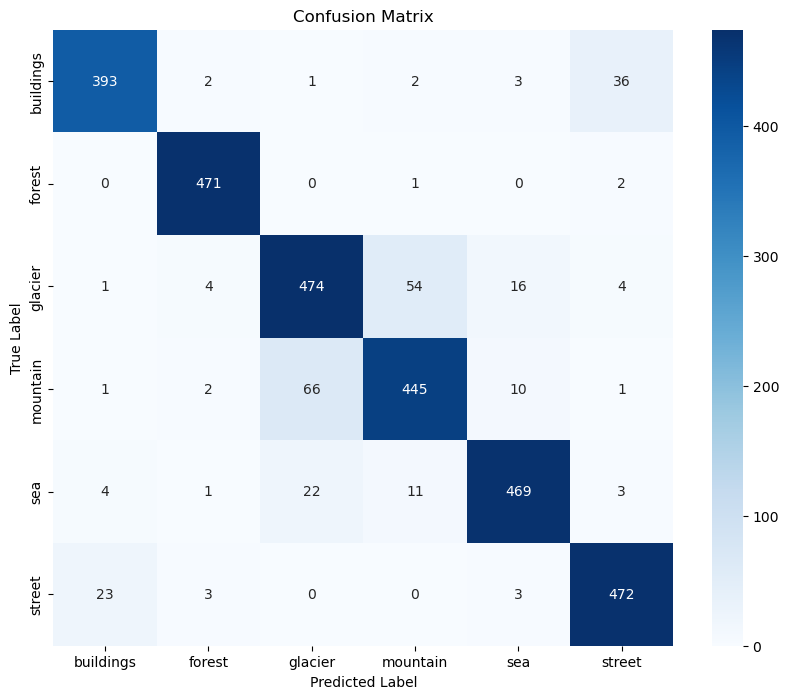

In [81]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


y_pred = efficient0.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert y_test from one-hot to integer labels
y_test_classes = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Replace 'class_names' with the actual list of class names
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()




**Interpretation**: 

Class imbalances are **not a major concern** based on the confusion matrix: Most classes are correctly classified with minor mistakes, mainly between similarly-looking classes (e.g. "mountain" and "glacier").

**Next Steps**: Moving on by building our own architecture.

### **Trying different model architectures from scratch**

#### **Simple Base Line model (architecture0)** - (3 convolutional layers with increasing filters, ReLU, max-pooling, dense layers, dropout)

In [17]:
# Define model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout 
from tensorflow.keras.optimizers import Adam

architecture0 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')  
])

architecture0.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


# Compile
architecture0.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])


/Users/juanbabeyhaut/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:
# Train the model with data augmentation
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = architecture0.fit(datagen.flow(x_train, y_train, batch_size=32),
                                 epochs=40,
                                 validation_data=(x_val, y_val),
                                 callbacks=[early_stopping])

Epoch 1/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.7359 - loss: 0.7376 - val_accuracy: 0.7833 - val_loss: 0.5922
Epoch 2/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.7211 - loss: 0.7776 - val_accuracy: 0.7850 - val_loss: 0.5968
Epoch 3/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.7336 - loss: 0.7497 - val_accuracy: 0.7850 - val_loss: 0.5706
Epoch 4/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.7314 - loss: 0.7654 - val_accuracy: 0.7900 - val_loss: 0.5697
Epoch 5/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.7251 - loss: 0.7570 - val_accuracy: 0.7908 - val_loss: 0.5719
Epoch 6/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.7306 - loss: 0.7286 - val_accuracy: 0.7958 - val_loss: 0.5748
Epoch 7/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.7417 - loss: 0.7273 - val_accuracy: 0.8075 - val_loss: 0.5340
Epoch 8/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.7528 - loss: 0.7016 - val_accu

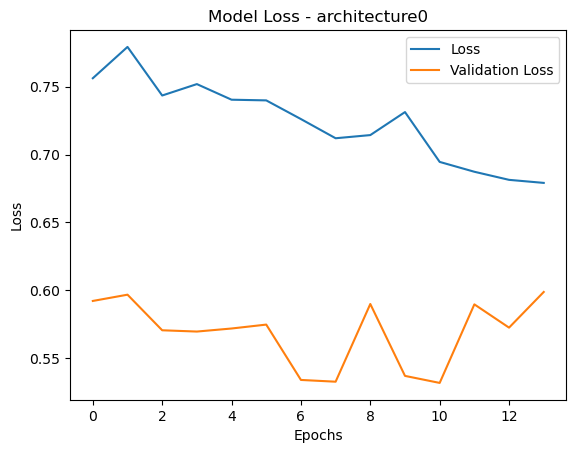

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8099 - loss: 0.5296
Test accuracy: 0.81


In [40]:
# Evaluation

plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss - architecture0")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

test_loss, test_accuracy = architecture0.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")

**Interpretation**: From the model loss plot:
**Benchmark** test accuracy: **0.81**
**Training Loss** is steadily decreasing but does not match validation loss perfectly (possible under-regularization; instability in optimization might be resolved by fine-tuning lr.), and **Validation Loss** shows slight fluctuations but is generally stable and lower than the training loss. This indicates good generalization and that the model is not overfitting.

Possible underfitting — model hasn’t yet captured enough complexity to generalize better.

**Next steps** Increase model complexity

#### **Increasing Complexity (architecture1)** - Added:
- fourth convo block with 256 filters
- increased size of dense layer to 512 units
- Batch normalisation (to scale features and speed up computational time)

In [23]:
# Define model 

from tensorflow.keras.layers import BatchNormalization

architecture1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(512, activation='relu'),  # Increased dense layer size
    Dropout(0.5),
    Dense(6, activation='softmax')
])


# Compile
architecture1.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


/Users/juanbabeyhaut/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
# Train the model with data augmentation

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = architecture1.fit(datagen.flow(x_train, y_train, batch_size=32),
                                 epochs=20,
                                 validation_data=(x_val, y_val),
                                 callbacks=[early_stopping])

Epoch 1/20


/Users/juanbabeyhaut/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.4048 - loss: 2.1860 - val_accuracy: 0.1992 - val_loss: 3.2569
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.5481 - loss: 1.2278 - val_accuracy: 0.2767 - val_loss: 2.4434
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.6151 - loss: 1.0500 - val_accuracy: 0.5342 - val_loss: 1.3708
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.6325 - loss: 0.9824 - val_accuracy: 0.7117 - val_loss: 0.7530
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.6425 - loss: 0.9501 - val_accuracy: 0.6858 - val_loss: 0.8522
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.6786 - loss: 0.8799 - val_accuracy: 0.7067 - val_loss: 0.7556
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.6728 - loss: 0.8416 - val_accuracy: 0.5192 - val_loss: 1.3174


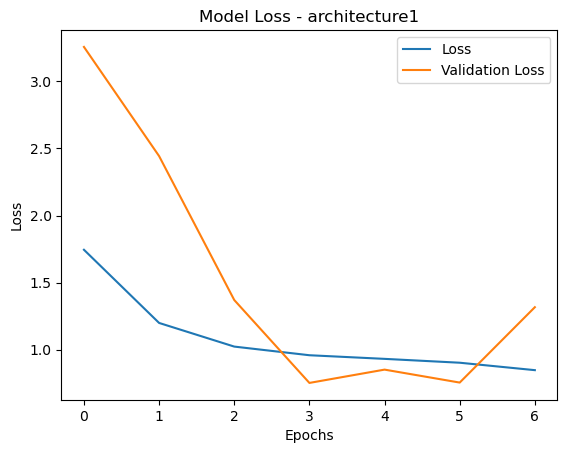

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7325 - loss: 0.7530
Test accuracy: 0.69


In [25]:
# Evaluation

plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss - architecture1")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

test_loss, test_accuracy = architecture1.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")

**Interpretation**: Low test accuracy (0.69) with slightly higher training accuracy (0.73), likely caused by overfitting due to increased model complexity or insufficient regularization.

Fluctuations in validation loss could indicate that the model is unstable, possibly due to:
- A high learning rate.
- Insufficient regularization (dropout, L1, L2).
- Too much model complexity for the dataset size.

**Next steps**: Increase regularization (dropout, L2), lower learning rate (from 1e-3 to 1e-4)

#### **Handling Overfitting (architecture2)** - Increase regularization, lower learning rate, reduce number of filters in Dense layer.

In [27]:
# Define model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2

architecture2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),   # Added dropout (gradually)

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)), # Reduced filters and learning rate
    Dropout(0.5),
    Dense(6, activation='softmax')
])

# Compile
architecture2.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


In [32]:
# Fit
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = architecture2.fit(datagen.flow(x_train, y_train, batch_size=32),
                            epochs = 40,
                            validation_data = (x_val, y_val),
                            callbacks = early_stopping)

Epoch 1/40


/Users/juanbabeyhaut/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.6325 - loss: 2.7350 - val_accuracy: 0.6025 - val_loss: 2.9476
Epoch 2/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.6584 - loss: 2.5814 - val_accuracy: 0.6542 - val_loss: 2.6131
Epoch 3/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.6412 - loss: 2.4964 - val_accuracy: 0.6433 - val_loss: 2.6533
Epoch 4/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.6706 - loss: 2.3696 - val_accuracy: 0.6475 - val_loss: 2.4084
Epoch 5/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.6566 - loss: 2.2918 - val_accuracy: 0.6600 - val_loss: 2.2533
Epoch 6/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.6726 - loss: 2.1644 - val_accuracy: 0.6508 - val_loss: 2.3020
Epoch 7/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.6682 - loss: 2.0897 - val_accuracy: 0.6967 - val_loss: 2.0520
Epoch 8/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.6754 - loss: 2.0345 - val_accuracy: 0

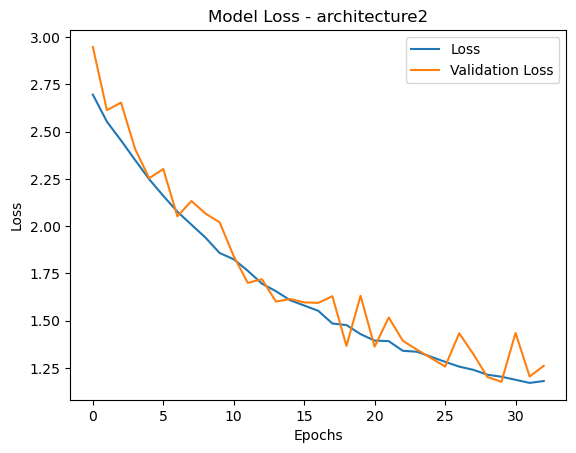

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8076 - loss: 1.0908
Test accuracy: 0.76


In [33]:
# Evaluation

plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss - architecture2")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

test_loss, test_accuracy = architecture2.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")

**Interpretation**: 

**Test Accuracy:** Improved to 76%, but still lower than the 81%% of the base model efficient0. (Adjustments are helping somewhat but are not sufficient).

**Converged Curves:** Both loss curves converged, not overfitting and could benefit from more complexity to generalize better.

**Validation Loss Spikes:** (model is unstable during training).
The L2 regularization (0.01) might be too strong, penalizing weights excessively and limiting the model's ability to fit the data.
Dropout might also be overly aggressive, leading to unstable updates during training.

**Plateau in Test Accuracy:**
The model might be underpowered due to reduced filter sizes or overly penalized by regularization.


**Next Steps**: Further fine-tuning

#### **Handling model instability (architecture3)** - Exploring fine-tuning regularization term (lowering it to 0.001) and removing initial dropout layers

In [34]:
# Define model
architecture3 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
                                    # Removed dropout

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
                                    # Removed dropout

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),   # lower regularization value
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Dense Layers
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(6, activation='softmax')
])


# Compile
architecture3.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


/Users/juanbabeyhaut/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
# Fit
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history = architecture3.fit(datagen.flow(x_train, y_train, batch_size=32),
                            epochs = 60,
                            validation_data = (x_val, y_val),
                            callbacks = early_stopping)

Epoch 1/60


/Users/juanbabeyhaut/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.6354 - loss: 1.8785 - val_accuracy: 0.7300 - val_loss: 1.6247
Epoch 2/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.6405 - loss: 1.8536 - val_accuracy: 0.7150 - val_loss: 1.6893
Epoch 3/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.6757 - loss: 1.7911 - val_accuracy: 0.7333 - val_loss: 1.6475
Epoch 4/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.6659 - loss: 1.7998 - val_accuracy: 0.7483 - val_loss: 1.5864
Epoch 5/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.6670 - loss: 1.7873 - val_accuracy: 0.7125 - val_loss: 1.6470
Epoch 6/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.6697 - loss: 1.7459 - val_accuracy: 0.7492 - val_loss: 1.5824
Epoch 7/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.6611 - loss: 1.7743 - val_accuracy: 0.7375 - val_loss: 1.5721
Epoch 8/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.7036 - loss: 1.6920 - val_accurac

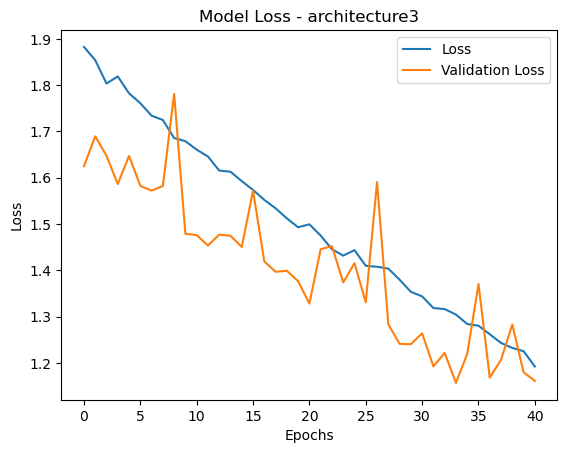

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8449 - loss: 1.1336
Test accuracy: 0.82


In [38]:
# Evaluation

plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss - architecture3")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

test_loss, test_accuracy = architecture3.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")

**Interpretation**: 

**Validation Loss Fluctuations**: While the validation loss spikes less than before, some instability remains. This suggests the model is sensitive to changes in the dataset or needs more fine-tuning.

**Performance Improvement**: The test accuracy of **82%** is a clear improvement over previous attempts, showing the adjusted architecture and training parameters are moving in the right direction.

**Overfitting Not Evident**: Training and validation losses follow similar trends, so overfitting is not a significant concern yet.

**Next Steps**: Add complexity (additional convo block) and fine tune regularization value (lower to 0.0001)

#### **Adding complexity and Fine tunning (architecture4)** - Additional convo block and lower regularization value (from 0.001 to 0.0001)

In [43]:
# Define model
from tensorflow.keras.callbacks import ReduceLROnPlateau

architecture4 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0001), padding='same'),   # Lowered regularization value to from 0.001 to 0.0001
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0001), padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.0001), padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Additional fifth conv block (New)
    Conv2D(512, (3, 3), activation='relu', kernel_regularizer=l2(0.0001), padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.3),
    Dense(6, activation='softmax')
])


# Compile 
architecture4.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])



/Users/juanbabeyhaut/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Define Callbacks
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     
    factor=0.5,             
    patience=3,              
    min_lr=1e-6              
)

early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Fit
history = architecture4.fit(
    x_train, y_train,                 
    validation_data=(x_val, y_val),   
    epochs=60,                        
    batch_size=32,                  
    callbacks=[lr_scheduler, early_stopping] 
)


Epoch 1/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 100ms/step - accuracy: 0.3858 - loss: 2.0917 - val_accuracy: 0.1575 - val_loss: 2.8147 - learning_rate: 1.0000e-04
Epoch 2/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 15s 100ms/step - accuracy: 0.5269 - loss: 1.3956 - val_accuracy: 0.2883 - val_loss: 2.8630 - learning_rate: 1.0000e-04
Epoch 3/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 15s 97ms/step - accuracy: 0.5934 - loss: 1.2171 - val_accuracy: 0.4492 - val_loss: 1.7894 - learning_rate: 1.0000e-04
Epoch 4/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 95ms/step - accuracy: 0.6385 - loss: 1.0893 - val_accuracy: 0.6200 - val_loss: 1.1366 - learning_rate: 1.0000e-04
Epoch 5/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 95ms/step - accuracy: 0.6543 - loss: 1.0416 - val_accuracy: 0.6875 - val_loss: 0.9411 - learning_rate: 1.0000e-04
Epoch 6/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 95ms/step - accuracy: 0.6678 - loss: 1.0037 - val_accuracy: 0.7342 - val_loss: 0.8548 - learning_rate: 1.0000e-04
Epoch 7/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 95ms/s

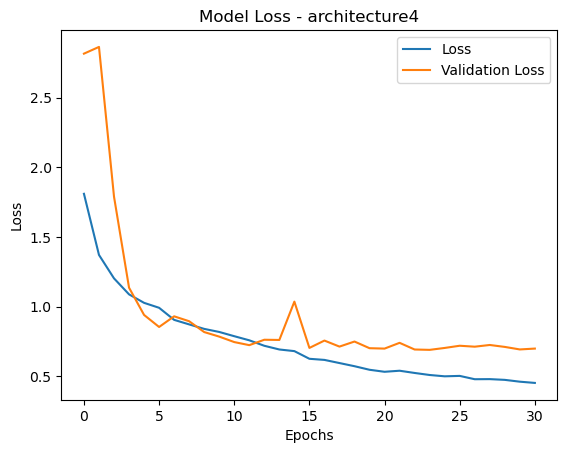

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8105 - loss: 0.6714
Test accuracy: 0.79


In [45]:
# Evaluation

plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss - architecture4")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

test_loss, test_accuracy = architecture4.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")

**interpretation**: 

**Validation loss** relatively stable until epoch 10 but there are still slight fluctuations (some instability still)
**Test accuracy decrease**: Adding a fifth convo layer did not help; dataset might not have enough samples to support the added complexity, leading to overfitting or inefficiency.

**Learning Rate Scheduler**: helped smooth out learning and convergence, but may not have been enough.

**Overfitting Risk**: fluctuations in validation loss and lower test accuracy suggest the model may be overfitting due to added complexity (extra convolutional block). Lowering L2 regularization across all layers may have reduced the penalty on big weights, increasing overfitting. Reducing dropout helped stability but may have opened space for overfitting. 


**Next Steps**: Remove fifth convo block, Reintroduce stronger L2 penalty (l2(0.001)) for deeper convo layers (as the reduced value (l2(0.0001)) may have allowed overfitting) - apply to the 3rd & 4rt convo blocks, refine dropout rates, increase lr to 1e-3 to speed-up learning (the lr scheduler will ensure smoothnes anyways).

#### **Scale back complexity & Fine-Tuning (architecture5)** - reduce model complexity, introduce higher penalization terms, and refined dropout

In [46]:
# Define model
architecture5 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3), padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0001), padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001), padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),   # Lowered dropout from 0.3 to 0.2

    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001), padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(6, activation='softmax')
])


# Compile
optimizer = Adam(learning_rate=1e-3) # Higher lr to speed up learning
architecture5.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])



/Users/juanbabeyhaut/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [47]:
# Callbacks
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

# Train 
history = architecture5.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=60,
    batch_size=32,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - accuracy: 0.4773 - loss: 3.7981 - val_accuracy: 0.2267 - val_loss: 6.3107 - learning_rate: 0.0010
Epoch 2/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.6444 - loss: 2.1072 - val_accuracy: 0.2517 - val_loss: 6.4618 - learning_rate: 0.0010
Epoch 3/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.7039 - loss: 1.8700 - val_accuracy: 0.4917 - val_loss: 3.1470 - learning_rate: 0.0010
Epoch 4/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.7250 - loss: 1.6961 - val_accuracy: 0.5633 - val_loss: 2.2887 - learning_rate: 0.0010
Epoch 5/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.7431 - loss: 1.5453 - val_accuracy: 0.5208 - val_loss: 2.5719 - learning_rate: 0.0010
Epoch 6/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.7761 - loss: 1.4279 - val_accuracy: 0.7092 - val_loss: 1.5346 - learning_rate: 0.0010
Epoch 7/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.8074 - l

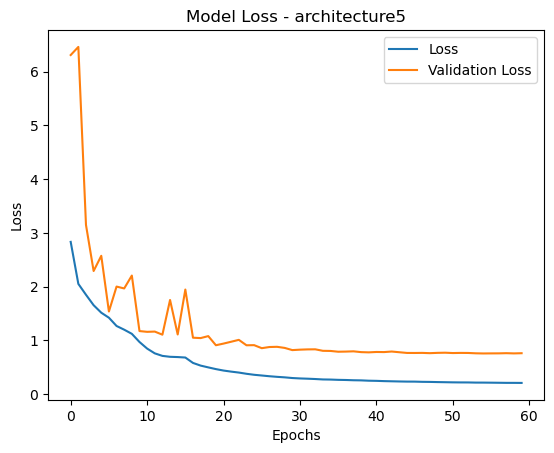

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8489 - loss: 0.9163
Test accuracy: 0.84


In [48]:
# Evaluation

plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss - architecture5")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

test_loss, test_accuracy = architecture5.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")

**Interpretation**:

The refinements worked, with improved regularization and dropout helping generalization.

The model generalizes reasonably well (**0.84%**, highest test accuracy from built acrchitectures so far), and no signs of overfitting.
However, the persistent gap between training and validation loss may indicate some **underfitting** or the need for **further fine-tuning**.

**Validation Loss Plateau:** The validation loss stabilizes after ~20 epochs, model has converged. The lack of significant spikes is a positive sign of training stability.



#### **Adding complexity while preventing overfitting (architecture6)** - Add fifth convo block with GlobalAveragePooling and dropout layers. Lower lr from 1e-3 to 1e-4.

In [50]:
# Define model
from tensorflow.keras.layers import GlobalAveragePooling2D

architecture6 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3), padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0001), padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001), padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001), padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Fifth Conv Block (back again but this time with GlobalAvegarePooling)
    Conv2D(512, (3, 3), activation='relu', kernel_regularizer=l2(0.001), padding='same'),
    BatchNormalization(),
    GlobalAveragePooling2D(),   # GlobalAveragePooling layer to simplify and prevent overfitting (performs better than Flatten() layer)
    Dropout(0.3),  # Dropout after GlobalAveragePooling2D to prevent overfitting

    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(6, activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=1e-4)    # Lowered lr (back again from 1e-3 to 1e-4)
architecture6.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [51]:
# Callbacks
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

# Train
history = architecture6.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    validation_data=(x_val, y_val),
    epochs=60,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/60


/Users/juanbabeyhaut/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step - accuracy: 0.4613 - loss: 2.4502 - val_accuracy: 0.1925 - val_loss: 3.4941 - learning_rate: 1.0000e-04
Epoch 2/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 17s 114ms/step - accuracy: 0.6219 - loss: 2.1128 - val_accuracy: 0.2583 - val_loss: 3.5871 - learning_rate: 1.0000e-04
Epoch 3/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - accuracy: 0.6571 - loss: 2.0027 - val_accuracy: 0.3917 - val_loss: 2.6217 - learning_rate: 1.0000e-04
Epoch 4/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - accuracy: 0.6826 - loss: 1.9157 - val_accuracy: 0.6575 - val_loss: 1.9380 - learning_rate: 1.0000e-04
Epoch 5/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 17s 114ms/step - accuracy: 0.6982 - loss: 1.8742 - val_accuracy: 0.7175 - val_loss: 1.7916 - learning_rate: 1.0000e-04
Epoch 6/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 17s 114ms/step - accuracy: 0.7058 - loss: 1.8193 - val_accuracy: 0.7392 - val_loss: 1.7079 - learning_rate: 1.0000e-04
Epoch 7/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - 

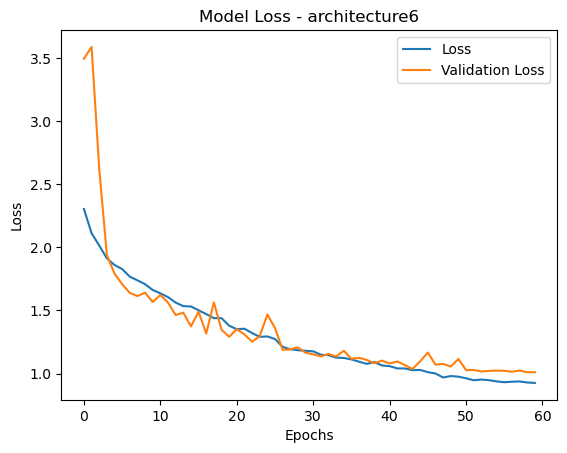

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8347 - loss: 1.0160
Test accuracy: 0.84


In [52]:
# Evaluation

plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss - architecture6")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

test_loss, test_accuracy = architecture6.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")

**Interpretation**:

**Training and Validation Loss Trends**:
Both decrease steadily and plateau, the model is converging well and is not overfitting.
Minimal gap between training and validation loss (good generalization).

**Validation Loss Fluctuations**:
Minor fluctuations in validation loss, no significant instability.

**Test Accuracy Stagnation (84%)**:
Despite all the fine-tuning, test accuracy hasn’t improved beyond 84%.
This suggests the current architecture and dataset have reached their capacity in extracting meaningful patterns for the task.

#### Trying **same architecture** but with **higher resolution images 96x96 (architecture7)** - No changes in architecture

In [64]:
# Train
history = architecture6.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    validation_data=(x_val, y_val),
    epochs=60,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 248ms/step - accuracy: 0.8674 - loss: 0.9316 - val_accuracy: 0.8542 - val_loss: 0.9846 - learning_rate: 1.0000e-06
Epoch 2/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 39s 256ms/step - accuracy: 0.8580 - loss: 0.9315 - val_accuracy: 0.8525 - val_loss: 0.9874 - learning_rate: 1.0000e-06
Epoch 3/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 237ms/step - accuracy: 0.8733 - loss: 0.9257 - val_accuracy: 0.8550 - val_loss: 0.9875 - learning_rate: 1.0000e-06
Epoch 4/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 35s 230ms/step - accuracy: 0.8711 - loss: 0.9273 - val_accuracy: 0.8508 - val_loss: 0.9856 - learning_rate: 1.0000e-06
Epoch 5/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 236ms/step - accuracy: 0.8715 - loss: 0.9093 - val_accuracy: 0.8525 - val_loss: 0.9871 - learning_rate: 1.0000e-06
Epoch 6/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 35s 232ms/step - accuracy: 0.8725 - loss: 0.9182 - val_accuracy: 0.8550 - val_loss: 0.9843 - learning_rate: 1.0000e-06
Epoch 7/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 23

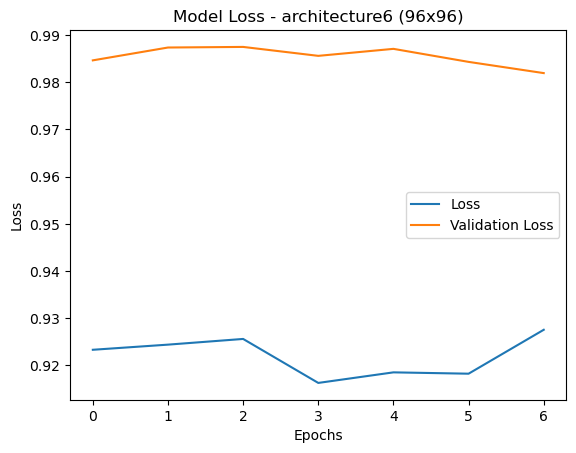

94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8604 - loss: 0.9650
Test accuracy: 0.84


In [65]:
# Evaluation

plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss - architecture6 (96x96)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

test_loss, test_accuracy = architecture6.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")

**Interpretation**:
**Test Accuracy Stagnation (84%)**:
test accuracy hasn’t improved beyond 84%, meaning the resolution reduction did not compromise the model's performance.
This suggests the current architecture and dataset have reached their capacity in extracting meaningful patterns for the task. The reasons why the model is not improving might have to do with the limited size and variability of the dataset.

### **Predicting Unseen Images**

We are going to use the **seg_pred** dataset, which are unlabelled images, for the model to predict on. We will then measure the accuracy and see how it compares to the test results.
EfficientNetB0 is our best model with 91% test accuracy, and we'll use 96x96 images to maintain consistency with training.

In [120]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import random
import matplotlib.pyplot as plt

In [121]:
# Function to load unlabeled data from the source folder
def load_unlabeled_images(data_dir, size=(96, 96)):
    images = []
    filenames = []

    # Loop through all files in the data_dir (no subdirectories)
    for img_name in os.listdir(data_dir):
        img_path = os.path.join(data_dir, img_name)

        try:
            # Skip hidden files (e.g., .DS_Store on macOS or Thumbs.db on Windows)
            if img_name.startswith('.') or not img_name.endswith(('.jpg', '.jpeg', '.png')):
                continue

            # Check if it's a valid image file
            if os.path.isfile(img_path):
                # Open the image, resize it, and convert to a numpy array
                img = Image.open(img_path)
                img = img.resize(size)  # Resize to the target size
                img_array = np.array(img)

                # Append the image and its filename to the lists
                images.append(img_array)
                filenames.append(img_name)
                print(f"Loaded image: {img_path}")  # Log the loaded images (can be removed later)

        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

    # Convert the list of images to a numpy array
    images = np.array(images)

    print(f"Total images loaded: {images.shape[0]}")  # Log the total number of images loaded
    return images, filenames

In [122]:
data_dir_pred = '../data/seg_pred'

# Load the unlabeled images
pred_images, filenames = load_unlabeled_images(data_dir_pred)
    
# Preprocess the images (normalize)
pred_images = pred_images / 255.0  # Normalizing to [0, 1] range if needed

Loaded image: ../data/seg_pred/63.jpg
Loaded image: ../data/seg_pred/24084.jpg
Loaded image: ../data/seg_pred/13628.jpg
Loaded image: ../data/seg_pred/3578.jpg
Loaded image: ../data/seg_pred/1409.jpg
Loaded image: ../data/seg_pred/23099.jpg
Loaded image: ../data/seg_pred/9041.jpg
Loaded image: ../data/seg_pred/4203.jpg
Loaded image: ../data/seg_pred/9727.jpg
Loaded image: ../data/seg_pred/77.jpg
Loaded image: ../data/seg_pred/24090.jpg
Loaded image: ../data/seg_pred/837.jpg
Loaded image: ../data/seg_pred/3544.jpg
Loaded image: ../data/seg_pred/13614.jpg
Loaded image: ../data/seg_pred/7044.jpg
Loaded image: ../data/seg_pred/17300.jpg
Loaded image: ../data/seg_pred/18033.jpg
Loaded image: ../data/seg_pred/5647.jpg
Loaded image: ../data/seg_pred/2128.jpg
Loaded image: ../data/seg_pred/4559.jpg
Loaded image: ../data/seg_pred/7050.jpg
Loaded image: ../data/seg_pred/12278.jpg
Loaded image: ../data/seg_pred/1347.jpg
Loaded image: ../data/seg_pred/7736.jpg
Loaded image: ../data/seg_pred/8405.j

In [123]:
def predict_and_display_random_images(model):
    # Predict the class probabilities
    predictions = model.predict(pred_images)

    # Get the predicted class labels (argmax to get the class with the highest probability)
    predicted_labels = np.argmax(predictions, axis=1)

    # Select 40 random indices to display 40 random images
    random_idxs = random.sample(range(len(pred_images)), 40)  # Get 40 random indices

    # Create a grid for displaying images (10 rows, 4 columns)
    fig, axes = plt.subplots(10, 4, figsize=(16, 40))  # Create a 10x4 grid (10 rows, 4 columns)
    axes = axes.flatten()  # Flatten the axes array to easily iterate

    # Map the predicted label to its class name (replace with your actual class names)
    class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']  # Example class names

    # Loop through the selected 40 images
    for i, idx in enumerate(random_idxs):
        # Get the random image, predicted label, and filename
        random_image = pred_images[idx]
        predicted_label = predicted_labels[idx]
        filename = filenames[idx]

        predicted_class_name = class_names[predicted_label]
        confidence = np.max(predictions[idx]) * 100  # Confidence as percentage

        # Display the image with the predicted label and confidence on top
        axes[i].imshow(random_image)
        axes[i].set_title(f"{predicted_class_name} ({confidence:.2f}%)", fontsize=8, color='white', backgroundcolor='black')
        axes[i].axis('off')  # Hide the axes for each subplot

    # Hide any extra axes if there are fewer than 40 images
    for i in range(len(random_idxs), len(axes)):
        axes[i].axis('off')

    # Show the plot with all 40 images
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()


207/207 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step


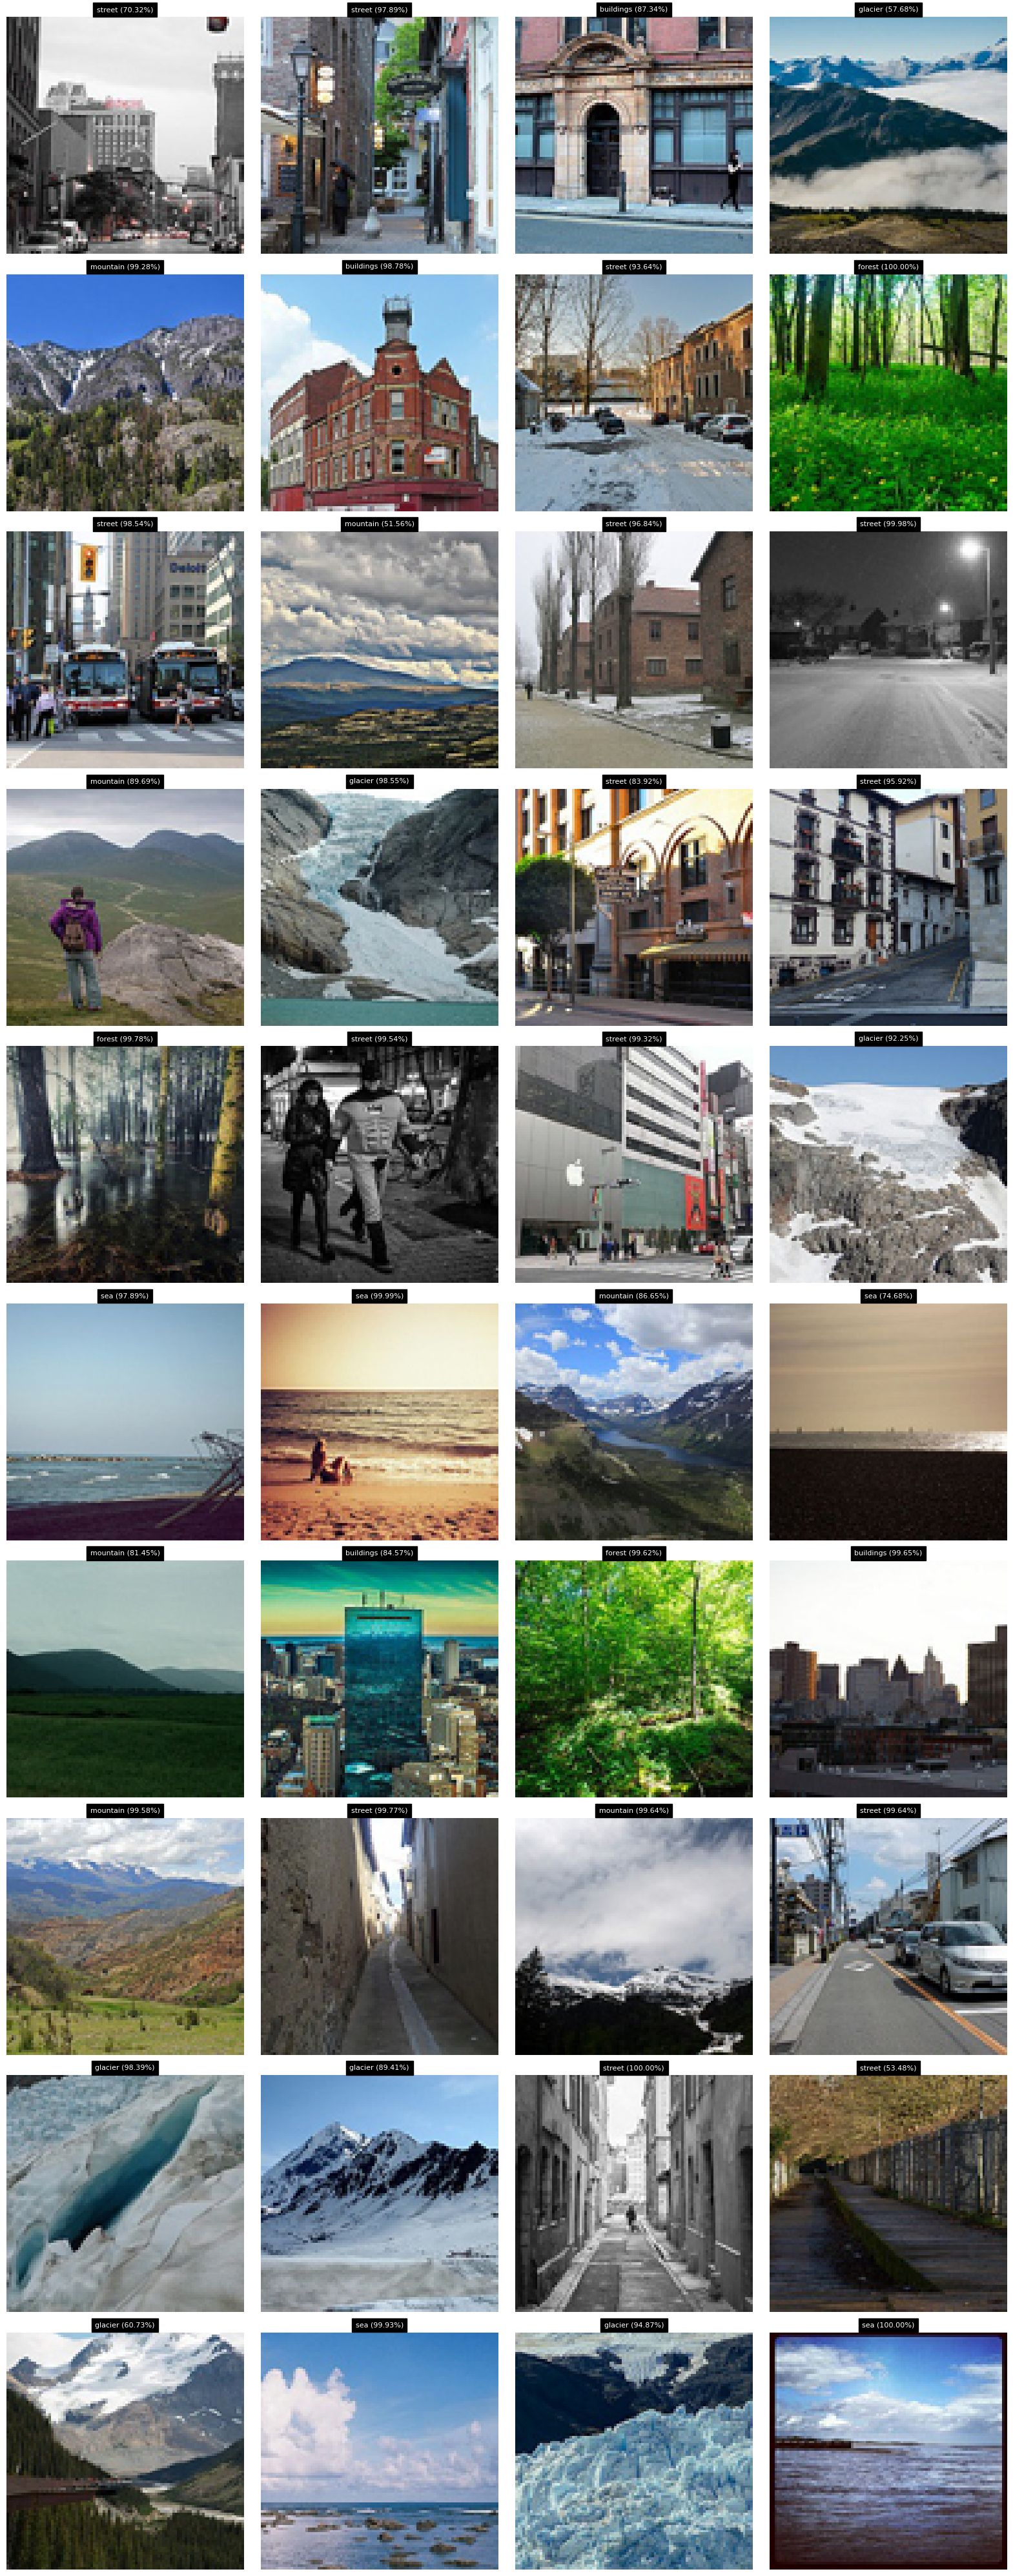

In [124]:
predict_and_display_random_images(efficient0)